# RESULTS NMNIST

In [ ]:
%load_ext autoreload
%autoreload 2

FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/home/antoine/homhots/hotsline/notebooks']

In [4]:
%cd ../hots
import tonic, torch, os, pickle, copy
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import apply_jitter, get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [6]:
kfold = None

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset, kfold=300)
trainloader = get_loader(trainset, kfold=kfold)
testloader = get_loader(testset, kfold=kfold)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 60000
number of samples in the testing set: 10000


## Initialization of the network

In [7]:
name = 'homeohots'
homeo = True
timestr = '2022-06-15'
dataset_name = 'nmnist'

Rz = [2, 4]
N_neuronz = [16, 32]
tauz = [1e4*2, 1e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = copy.copy(hots.name)

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = copy.copy(hots_nohomeo.name)

## Unsupervised clustering

In [ ]:
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)

## Training of the classification layer

In [ ]:
drop_proba_mlr = .5
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 5e4


train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{num_sample_train}_{learning_rate}_{betas}_{num_epochs}_{drop_proba_mlr}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{num_sample_test}_{learning_rate}_{betas}_{num_epochs}_{drop_proba_mlr}_{jitter}.pkl'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)
hots.coding(testloader, trainset.ordering, testset.classes, training=False, verbose=False)

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

if drop_proba_mlr:
    drop_transform = tonic.transforms.DropEvent(p = drop_proba_mlr)
    trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([drop_transform, type_transform]))
    trainoutputloader = get_loader(trainset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)

train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

## Online Inference (Figure 4-(b))

In [ ]:
likelihood, true_target, timestamps = predict_mlr(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering)
score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])

In [ ]:
mlr_threshold = None
meanac, onlinac, lastac, best_probac = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, figure_name = 'nmnist_online.pdf')

In [ ]:
mlr_threshold = .99
meanac_thres, onlinac_thres, lastac_thres, best_probac_thres = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, figure_name = 'nmnist_online_.99.pdf')

In [ ]:
import matplotlib.pyplot as plt

event_90th = 5565
sampling = (np.logspace(0,np.log10(event_90th),100)).astype(int)

fig, ax = plt.subplots()
ax.semilogx(sampling[:-1],onlinac[sampling[:-1]]*100, '.', label='online HOTS (ours)');
ax.semilogx(sampling[:-1],onlinac_thres[sampling[:-1]]*100, '.', label='online HOTS \nwith threshold', alpha = .5);
ax.hlines(1/n_classes*100,0,event_90th, linestyles='dashed', color='k', label='chance level')
ax.hlines(score_nohomeo*100,0,event_90th, linestyles='dashed', color='r', label='original HOTS')
ax.hlines(score*100,0,event_90th, linestyles='dashed', color='g', label='HOTS with homeostasis')
ax.set_xlabel('Number of events', fontsize=16);
ax.axis([1,event_90th,0,101]);
#plt.title('LR classification results evolution as a function of the number of events');
plt.setp(ax.get_xticklabels(),fontsize=12)
#ax.set_yticks([])
plt.setp(ax.get_yticklabels(),fontsize=12)
ax.legend(fontsize=10, loc='upper left');
ax.set_ylabel('Accuracy (in %)', fontsize=16);
    #printfig(fig, figure_name)

In [ ]:
name = 'nmnist_online.pdf'

dpi_exp = None
bbox = 'tight'
path = '../../manuscript/fig/'
#path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

## Robustness to spatial jitter (Figure 5-(b)-(up))

In [ ]:
kfold_jitter = 10
nb_trials = 3
nb_points = 20
mlr_threshold = .65

trainset_output_jitter = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

In [ ]:
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output_jitter, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, mlr_threshold = mlr_threshold, fitting = True, verbose = True);

In [ ]:
jitter_path = '../Records/jitter_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_10_0_10_10_20_0'
data_stored = np.load(jitter_path+'.npz')
jitter_values = data_stored['arr_0']
scores_jit_single = data_stored['arr_1']
scores_jit_histo_single = data_stored['arr_2']
scores_jit_histo_nohomeo_single = data_stored['arr_3']

In [ ]:
print(scores_jit_single)
print(scores_jit_histo_single)
print(scores_jit_histo_nohomeo_single)

## Robustness to temporal jitter (Figure 5-(b)-(down))

In [ ]:
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output_jitter, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, mlr_threshold = mlr_threshold, fitting = True, verbose = True);

Number of chance decisions: 0
90th quantile for number of events: 112607.6
Mean accuracy: 26.5%
Last accuracy: 18.2%
Highest probability accuracy: 18.2%
Number of chance decisions: 0
90th quantile for number of events: 112607.6
Mean accuracy: 24.5%
Last accuracy: 22.7%
Highest probability accuracy: 22.7%
Number of chance decisions: 0
90th quantile for number of events: 112607.6
Mean accuracy: 53.400000000000006%
Last accuracy: 50.0%
Highest probability accuracy: 45.5%


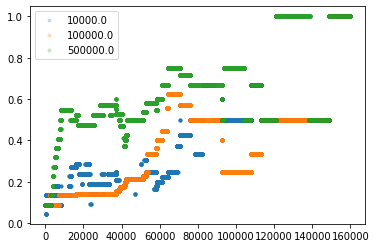

In [16]:
import pickle
for tau_cla in [1e4,1e5,5e5]:#,1e5,5e5,1e6,5e6,1e7]:
    file_name = f'../Records/LR_results/2022-04-22_gesture_homeohots_True_[16, 32]_[100000.0, 800000.0]_[4, 8]_{tau_cla}_0.0001_(0.9, 0.999)_11_(None, None)_0.9.pkl'
    
    with open(file_name, 'rb') as file:
        likelihood, true_target, timestamps = pickle.load(file)
        
    score = .95
    score_nohomeo = .95
    mlr_threshold = None
    meanac, onlinac, lastac, bestac = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)
    plt.plot(onlinac, '.', label=f'{tau_cla}', alpha=.2)
plt.legend()

Number of chance decisions: 0
90th quantile for number of events: 112607.6
Mean accuracy: 21.3%
Last accuracy: 27.3%
Highest probability accuracy: 27.3%


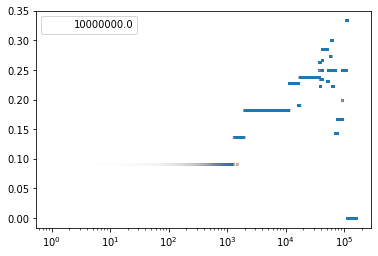

In [30]:
import pickle
for tau_cla in [1e7]:#,5e6,1e7]:
    file_name = f'../Records/LR_results/2022-04-22_gesture_homeohots_True_[16, 32]_[100000.0, 800000.0]_[4, 8]_{tau_cla}_0.0001_(0.9, 0.999)_11_(None, None)_0.9.pkl'
    
    with open(file_name, 'rb') as file:
        likelihood, true_target, timestamps = pickle.load(file)
        
    score = .95
    score_nohomeo = .95
    mlr_threshold = None
    meanac, onlinac, lastac, bestac = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)
    plt.semilogx(onlinac, '.', label=f'{tau_cla}', alpha=.002)
plt.legend()